In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import h5py
import scipy.signal

from scipy import fft
from pytdi import Data
from pytdi import michelson as mich

In [4]:
orbit_path = '../orbits.h5'

rec = ['X','Y','Z']
dur = [1000,5000,10000,50000,100000]

fs = 4

nspath = {}
nnpath = {}
for d in dur:
    nspath[d] = 'measurements/msrmnts' +str(d)+ '.h5'
    nnpath[d] = 'measurements/msrmnts' +str(d)+ '_nn.h5'

def psd_func(data):
    return scipy.signal.welch(data,fs=4,window='nuttall',nperseg=len(data),detrend=False)

In [5]:
discard = 300

nsdata = {}
nndata = {}
for d in dur:
    # Calculate no signal data
    rawdata = Data.from_instrument(nspath[d])

    X = mich.X2.build(**rawdata.args)(rawdata.measurements)[discard:]
    Y = mich.Y2.build(**rawdata.args)(rawdata.measurements)[discard:]
    Z = mich.Z2.build(**rawdata.args)(rawdata.measurements)[discard:]

    #t = inst_nosig.t[discard:]
    t = (np.arange(0,len(X)+discard)/4)[discard:]

    nsdata[d] = np.array([t,X,Y,Z])

    # Calculate no noise data
    rawdata = Data.from_instrument(nnpath[d])

    X = mich.X2.build(**rawdata.args)(rawdata.measurements)[discard:]
    Y = mich.Y2.build(**rawdata.args)(rawdata.measurements)[discard:]
    Z = mich.Z2.build(**rawdata.args)(rawdata.measurements)[discard:]

    #t = inst_nosig.t[discard:]
    t = (np.arange(0,len(X)+discard)/4)[discard:]

    nndata[d] = np.array([t,X,Y,Z])


In [6]:
# Calculate the psd and the fft of the data
psd_nsdata = {}
for d in dur:
    tmp = []
    for i in range(3):
        tmpf, tmppsd = psd_func(nsdata[d][i+1])
        tmp.append(tmppsd)
    psd_nsdata[d] = np.array([tmpf, tmp[0], tmp[1], tmp[2]])

fft_nndata = {}
for d in dur:
    fttmp = abs(fft.fft(nndata[d][1:]))
    fft_nndata[d] = np.array([fft.fftfreq(len(nndata[d][0]),1/fs), fttmp[0],fttmp[1],fttmp[2]])

In [8]:
# Calculate the SNR
SNR = []
for d in dur:
    df = (fft_nndata[d][0][1]-fft_nndata[d][0][0]) # width of frequency bin
    #fft and psd have values at same frequency so no interpolation is needed 

    tmp = []
    for i in range(3):
        FFT2 = (fft_nndata[d][i+1][:int(len(fft_nndata[d][i+1])/2)])**2 #select the right part of the FFT spectrum

        tmp2 = np.sqrt(np.sum(FFT2/psd_nsdata[d][i+1][:-1])*df)
        tmp.append(tmp2)
    SNR.append(tmp)
SNR = np.array(SNR)

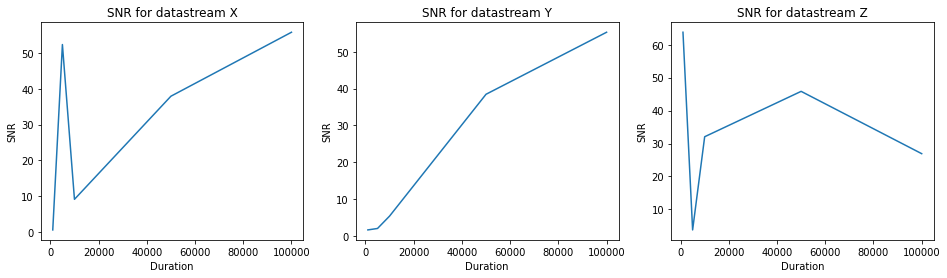

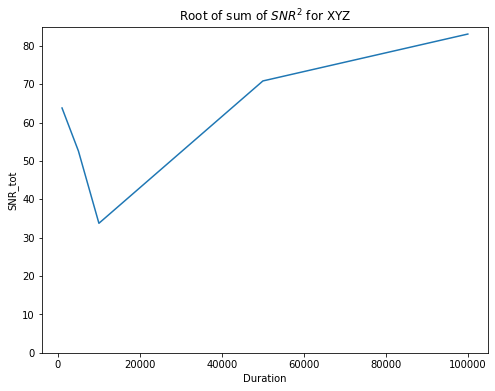

In [21]:
fig, axs = plt.subplots(1,3)
fig.set_figwidth(16)
for i in range(3):
    axs[i].plot(dur,SNR[:,i])
    axs[i].set_xlabel("Duration")
    axs[i].set_ylabel("SNR")
    axs[i].set_title("SNR for datastream "+rec[i])
plt.show()

plt.figure(figsize=(8,6))
plt.plot(dur,np.sqrt(np.sum(SNR**2,axis=1)))
plt.xlabel("Duration")
plt.ylabel("SNR_tot")
plt.ylim(0,85)
plt.title("Root of sum of $SNR^2$ for XYZ")
plt.show()